In [3]:
#pip install scipy pandas numpy statistics geojson plotly

In [238]:
from sqlalchemy import create_engine, text, inspect, Table
import pandas as pd
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import numpy as np

In [7]:
engine = create_engine("postgresql://student:infomdss@db_dashboard:5432/dashboard")

In [358]:
query_6 = '''SELECT * FROM electricity_consumption'''
con = engine.connect()
dfpred = pd.read_sql(query_6, con, index_col = "index" )

In [250]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

In [342]:
dfpred.drop("Unnamed: 0", axis = 1, inplace = True)
dfpred['DATE'] = pd.to_datetime(dfpred[['year', 'month']].assign(day=1))
dfpred.drop("year", axis = 1, inplace= True)
dfpred.drop("month", axis = 1, inplace = True)
dcountry = "AUT"
dindicator = "Consumption"
dfpred = dfpred[(dfpred["country"] == dcountry) & (dfpred["indicator"] == dindicator)]
#dfpred["DATE"] = dfpred["DATE"].astype(str)
dfpred2 = dfpred[["DATE","gwh"]]
#dfpred2.dtypes
dfpred2.to_csv("elec_date.csv", index = False)

KeyError: "['Unnamed: 0'] not found in axis"

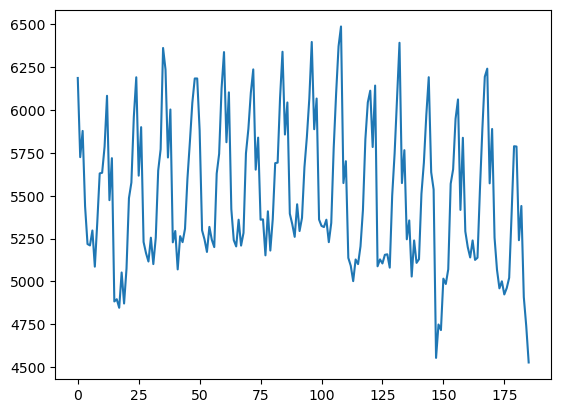

In [252]:
# load and plot the time series dataset
from pandas import read_csv
from matplotlib import pyplot
# load dataset
series = read_csv('elec_date.csv', header=0, index_col=0)
values = series.values
# plot dataset
pyplot.plot(values)
pyplot.show()

>expected=5000.6, predicted=5170.8
>expected=4923.9, predicted=5025.5
>expected=4961.2, predicted=5107.1
>expected=5021.2, predicted=5400.2
>expected=5395.3, predicted=5359.7
>expected=5788.7, predicted=5549.6
>expected=5787.0, predicted=5935.4
>expected=5240.4, predicted=6018.5
>expected=5440.1, predicted=5641.5
>expected=4908.5, predicted=5694.7
>expected=4739.4, predicted=5266.0
>expected=4526.9, predicted=4916.5
MAE: 325.140


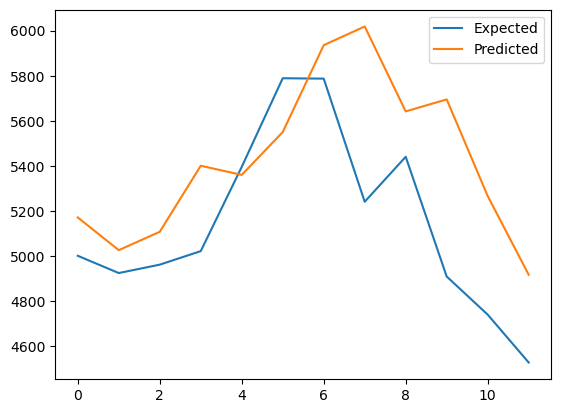

In [287]:
# forecast monthly births with random forest
## DIT MOet ER NIET IN DIT IS ALLEEN OM DE PARAMETERS TE OPTIMALISEREN GA IK NOG DOEN
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(max_depth= None, max_features="sqrt", min_samples_leaf= 1, min_samples_split=2, n_estimators=500)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
series = read_csv('elec_date.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [281]:
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# load a smaller sample of the dataset
series = read_csv('elec_date.csv', header=0, index_col=0, nrows=100)  # Adjust nrows to your desired sample size
values = series.values

# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6, n_out=6)  # Reduce n_in and n_out for a smaller sample
# split into input and output columns
trainX, trainy = train[:, :-6], train[:, -6:]

# Define hyperparameters to try
hyperparameters = {
    'n_estimators': [100, 500],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

# Create RandomForestRegressor
rf_model = RandomForestRegressor()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf_model, param_grid=hyperparameters, cv=3)
grid_result = grid_search.fit(trainX, trainy)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_result.best_params_)

# fit model with the best hyperparameters
best_model = RandomForestRegressor(**grid_result.best_params_)
best_model.fit(trainX, trainy)

# construct an input for a new prediction
row = values[-6:].flatten()

# make a 6-step prediction (adjust to your desired prediction steps)
yhat = best_model.predict(asarray([row]))
print('Input: %s, Predicted: %s' % (row, yhat))


/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/conda/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.11/site-packages/sklearn/utils/

Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Input: [5843. 6067. 6397. 5888. 6067. 5361.], Predicted: [[5305.778 5211.604 5380.498 5240.204 5347.232 5666.976]]


In [294]:
# DIT IS DE UITEINDELIJKE PREDICTOR NOg niet geoptimaliseerd nu
# als je de maanden wil aanpassen doe je n_out in de onderste naar meer maanden en
# {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# load the dataset
series = read_csv('elec_date.csv', header=0, index_col=0)
#series = dfpred2["gwh"]
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=50, n_out=40)  # Update n_out to 40
# split into input and output columns
trainX, trainy = train[:, :-40], train[:, -40:]  # Separate the last 40 columns as output
# fit model with the optimised hyperparameters
model = RandomForestRegressor(max_depth= None, max_features="sqrt", min_samples_leaf= 1, min_samples_split=2, n_estimators=500)
model.fit(trainX, trainy)
# construct an input for a new prediction
row = values[-50:].flatten()

# make the prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %s' % (row, yhat))

Input: [5355.76  5028.373 5238.936 5108.134 5129.621 5510.255 5692.274 5970.166
 6191.459 5637.256 5536.454 4553.688 4748.615 4715.88  5016.111 4984.917
 5070.661 5569.589 5653.941 5948.676 6061.711 5417.159 5837.977 5292.216
 5200.376 5139.668 5238.894 5125.441 5138.257 5534.87  5889.139 6194.275
 6241.162 5572.221 5889.35  5254.954 5067.914 4959.545 5000.562 4923.9
 4961.22  5021.191 5395.307 5788.714 5787.018 5240.429 5440.089 4908.547
 4739.386 4526.915], Predicted: [[5278.725122 5246.395176 5327.118204 5610.753936 5808.573488 6012.453466
  6130.515348 5789.55724  5773.80029  5335.655498 5242.397644 5182.392404
  5260.039132 5233.323242 5325.853154 5624.683462 5818.088698 6003.28463
  6105.493494 5724.99243  5702.777422 5306.007862 5226.040034 5156.395134
  5242.665046 5209.567754 5317.62444  5597.456654 5809.702398 6010.161348
  6109.83185  5738.80237  5707.496156 5269.312852 5181.658418 5137.054358
  5197.839192 5181.064436 5270.896824 5537.213902]]


In [302]:
from numpy import asarray
from pandas import DataFrame, concat, read_csv
from sklearn.ensemble import RandomForestRegressor

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

def random_forest_predict(df):
    n_in = 50
    n_out = 40
    # transform the time series data into supervised learning
    values = df.values
    train = series_to_supervised(values, n_in=n_in, n_out=n_out)
    # split into input and output columns
    trainX, trainy = train[:, :-n_out], train[:, -n_out:]  # Separate the last n_out columns as output

    # fit model with the provided hyperparameters
    model = RandomForestRegressor(max_depth= None, max_features="sqrt", min_samples_leaf= 1, min_samples_split=2, n_estimators=500)
    model.fit(trainX, trainy)

    # construct an input for a new prediction
    row = values[-n_in:].flatten()

    # make the prediction
    yhat = model.predict(asarray([row]))

    return yhat

# load the dataset
#series = read_csv('elec_date.csv', header=0, index_col=0)
df = pd.read_csv('elec_date.csv', header=0, index_col=0)
#values = series.values


# make a prediction
prediction = random_forest_predict(df)
print('Predicted: %s' % prediction)

Predicted: [[5288.627486 5277.94773  5355.987228 5634.975758 5811.902358 5983.578748
  6116.605426 5761.56772  5771.256374 5355.925942 5265.820906 5196.389286
  5281.867752 5262.088644 5362.470736 5645.65926  5830.294956 5987.736838
  6103.02935  5709.262994 5699.371734 5305.227968 5244.713742 5170.729208
  5257.513054 5244.703004 5351.67138  5626.0331   5823.713192 5991.859846
  6111.558168 5723.989514 5721.813282 5295.16545  5211.773856 5155.810036
  5216.3668   5215.665774 5307.738292 5567.27185 ]]


In [309]:
#resultsplot = pd.DataFrame(series)

resultsplot = df
resultsplot = resultsplot.reset_index()
resultsplot["DATE"] = pd.to_datetime(resultsplot["DATE"])
resultsplot["predict"] = False

In [313]:
result = prediction.reshape(-1)
for value in result:
    last_date = resultsplot["DATE"].max()
    new_date = last_date + pd.DateOffset(months=1)
    list_row = [new_date, value, True]
    resultsplot.loc[len(resultsplot)] = list_row
resultsplot.tail(7)
    

,DATE,gwh,predict
259,2029-08-01,5295.165450,True
260,2029-09-01,5211.773856,True
261,2029-10-01,5155.810036,True
262,2029-11-01,5216.366800,True
263,2029-12-01,5215.665774,True
264,2030-01-01,5307.738292,True
265,2030-02-01,5567.271850,True


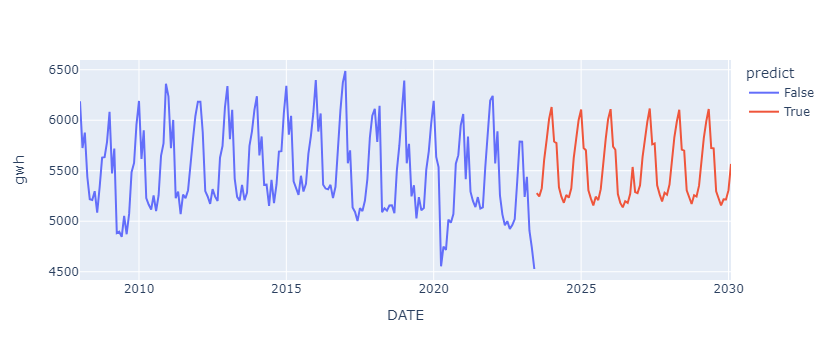

In [314]:
fig = px.line(resultsplot, x = "DATE",y ="gwh", color = "predict" )
fig.show()

In [357]:
def prediction(df):
    df.drop("Unnamed: 0", axis = 1, inplace = True)  # dit 
    df['DATE'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df.drop("year", axis = 1, inplace= True)
    df.drop("month", axis = 1, inplace = True)
    dcountry = "AUT"
    dindicator = "Consumption"
    df = df[(df["country"] == dcountry) & (df["indicator"] == dindicator)]
    #dfpred["DATE"] = dfpred["DATE"].astype(str)
    dfpred2 = df[["DATE","gwh"]]
    dfpred2.set_index('DATE', inplace = True)
    prediction = random_forest_predict(dfpred2)
    return prediction, dfpred2
    

In [339]:
prediction(dfpred)

(array([[5279.991382, 5272.748788, 5353.159136, 5620.538544, 5812.127868,
         6008.81381 , 6107.662258, 5795.323756, 5748.823174, 5373.015284,
         5257.177146, 5182.951932, 5260.645944, 5257.08934 , 5359.480592,
         5638.931924, 5826.65156 , 5991.700214, 6079.62541 , 5758.044358,
         5689.817074, 5320.93991 , 5236.316858, 5164.365922, 5249.411484,
         5236.647578, 5345.502074, 5612.971718, 5809.420272, 5997.881386,
         6090.356452, 5762.302484, 5714.606226, 5332.94505 , 5220.604692,
         5158.473116, 5217.383918, 5215.652886, 5302.122992, 5556.636918]]),
                  gwh
 DATE                
 2008-01-01  6187.000
 2008-02-01  5725.000
 2008-03-01  5878.000
 2008-04-01  5438.000
 2008-05-01  5218.000
 ...              ...
 2023-02-01  5240.429
 2023-03-01  5440.089
 2023-04-01  4908.547
 2023-05-01  4739.386
 2023-06-01  4526.915
 
 [186 rows x 1 columns])

In [356]:
def show_plot(df):
    predresult = prediction(df)
    resultsplot = predresult[1]
    resultsplot = resultsplot.reset_index()
    resultsplot["DATE"] = pd.to_datetime(resultsplot["DATE"])
    resultsplot["predict"] = False
    result = predresult[0].reshape(-1)
    for value in result:
        last_date = resultsplot["DATE"].max()
        new_date = last_date + pd.DateOffset(months=1)
        list_row = [new_date, value, True]
        resultsplot.loc[len(resultsplot)] = list_row
    fig = px.line(resultsplot, x = "DATE",y ="gwh", color = "predict" )
    return fig


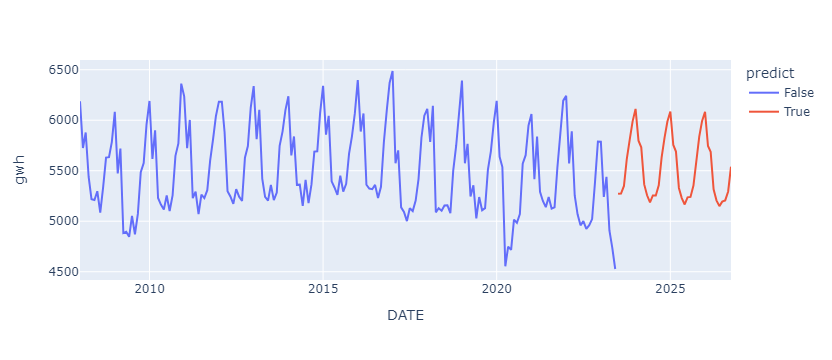

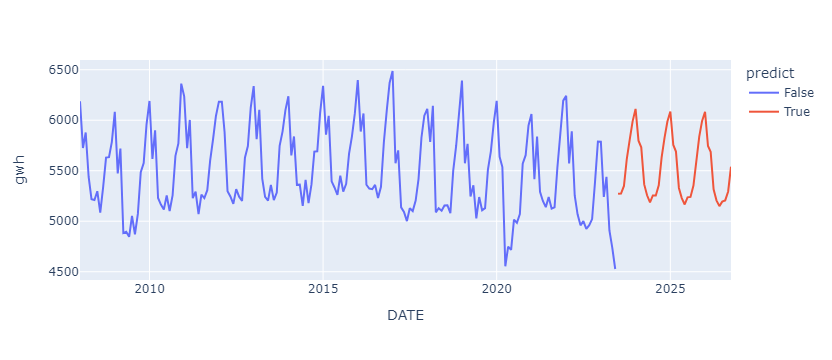

In [359]:
show_plot(dfpred)